# Support Vector Machines – Exploratory Analysis

This notebook explores **Support Vector Machines (SVM)** as an alternative modeling approach within the Liga MX probabilistic framework.

The objective is to understand how margin-based models behave in a football prediction context, particularly in terms of:
- Class separation
- Stability across probability regions
- Sensitivity to feature scaling and data structure

---

## 🎯 Objectives

- Evaluate SVMs as a contrast to linear and tree-based models
- Analyze decision boundaries in high-variance sports data
- Assess probabilistic stability when probabilities are derived from margins

This notebook is exploratory and intentionally constrained.

---

## 🧠 Modeling Context

SVMs are known for:
- Strong theoretical foundations
- Robust decision boundaries
- Effectiveness in complex feature spaces

However, in probabilistic modeling:
- Output probabilities are indirect
- Calibration becomes critical
- Interpretability is limited

This notebook investigates whether these trade-offs are acceptable in this domain.

---

## 🔬 Evaluation Focus

- Margin behavior and class separation
- Sensitivity to feature scaling
- Probability distribution sanity checks
- Comparison with calibrated logistic regression outputs

Results are evaluated primarily for **behavioral insights**, not raw performance.

---

## 🚧 Scope & Limitations

- No extensive kernel search
- Minimal hyperparameter tuning
- Focused on conceptual understanding

This notebook contributes to model comparison and helps define which model families are suitable for probabilistic football modeling.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))
DATA_DIR = PROJECT_ROOT / "data" / "processed"
df = pd.read_csv(DATA_DIR / "prematch_dataset_2023mx1.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   match_id        170 non-null    int64  
 1   date            170 non-null    object 
 2   home_advantage  170 non-null    int64  
 3   home_win        170 non-null    int64  
 4   home_team       170 non-null    object 
 5   away_team       170 non-null    object 
 6   home_form       170 non-null    float64
 7   away_form       170 non-null    float64
 8   form_diff       170 non-null    float64
 9   home_momentum   170 non-null    float64
 10  away_momentum   170 non-null    float64
 11  momentum_diff   170 non-null    float64
dtypes: float64(6), int64(3), object(3)
memory usage: 16.1+ KB


In [4]:
features = ["form_diff", "momentum_diff"]
target = "home_win"

X = df[features]
y = df[target]

In [5]:
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(C=1.0, penalty="l2"))
])

In [6]:
svm = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="linear", C=1.0))
])

In [7]:
log_reg.fit(X, y)
svm.fit(X, y)

c:\Users\USER\Python\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'


In [8]:
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(
        X.iloc[:, 0],
        X.iloc[:, 1],
        c=y,
        edgecolor="k",
        alpha=0.7
    )
    plt.xlabel("form_diff")
    plt.ylabel("momentum_diff")
    plt.title(title)
    plt.show()


c:\Users\USER\Python\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


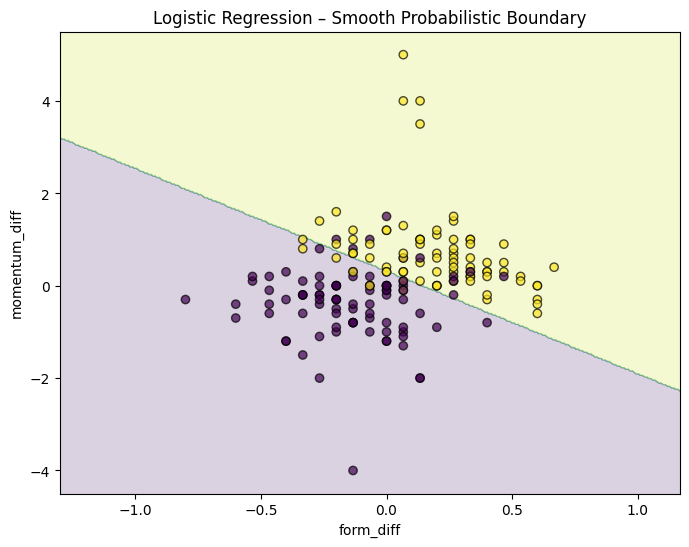

In [9]:
plot_decision_boundary(
    log_reg,
    X,
    y,
    "Logistic Regression – Smooth Probabilistic Boundary"
)


c:\Users\USER\Python\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


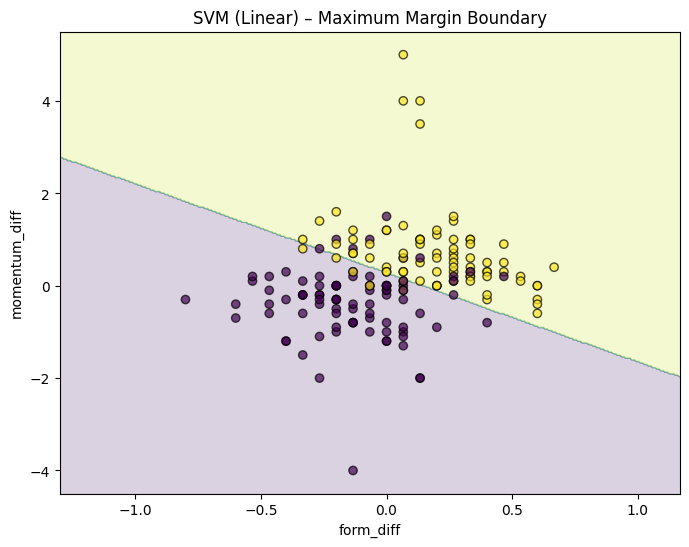

In [10]:
plot_decision_boundary(
    svm,
    X,
    y,
    "SVM (Linear) – Maximum Margin Boundary"
)


El SVM no busca probabilidades ni reglas jerárquicas.
Su frontera está determinada únicamente por los partidos cercanos al margen.

Esto explica por qué:

los árboles se sobreconfían en regiones amplias

la regresión logística puede inflar coeficientes

SVM revela zonas estructuralmente inciertas

In [11]:
svm_model = svm.named_steps["model"]
scaler = svm.named_steps["scaler"]

X_scaled = scaler.transform(X)

margin_distance = svm_model.decision_function(X_scaled)


Identificar la distancia a la frontera

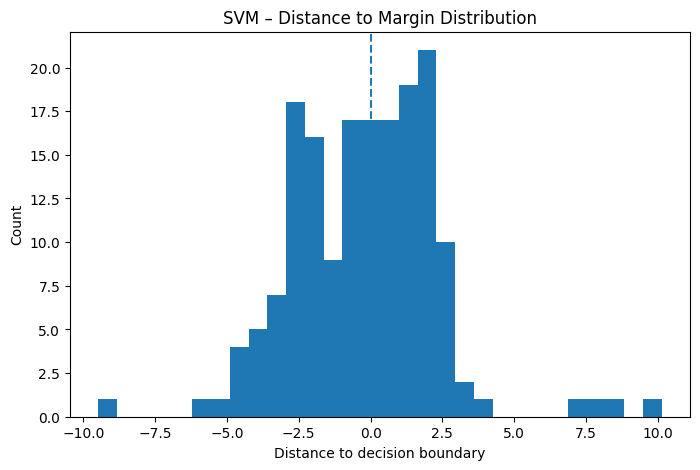

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(margin_distance, bins=30)
plt.axvline(0, linestyle="--")
plt.title("SVM – Distance to Margin Distribution")
plt.xlabel("Distance to decision boundary")
plt.ylabel("Count")
plt.show()


In [13]:
uncertain_mask = np.abs(margin_distance) < 0.3

X_uncertain = X[uncertain_mask]
y_uncertain = y[uncertain_mask]


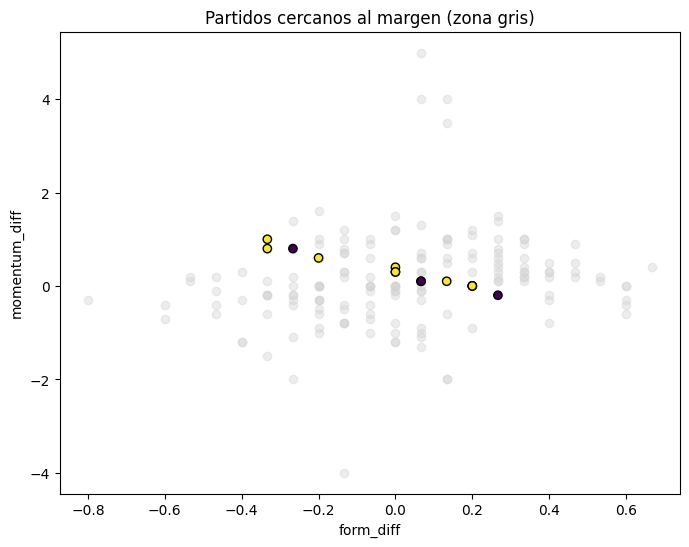

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(X["form_diff"], X["momentum_diff"], c="lightgray", alpha=0.4)
plt.scatter(
    X_uncertain["form_diff"],
    X_uncertain["momentum_diff"],
    c=y_uncertain,
    edgecolor="k"
)
plt.xlabel("form_diff")
plt.ylabel("momentum_diff")
plt.title("Partidos cercanos al margen (zona gris)")
plt.show()


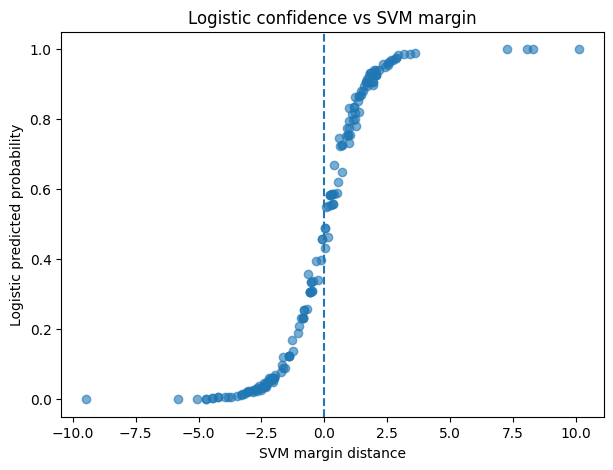

In [15]:
log_probs = log_reg.predict_proba(X)[:, 1]

plt.figure(figsize=(7, 5))
plt.scatter(margin_distance, log_probs, alpha=0.6)
plt.axvline(0, linestyle="--")
plt.xlabel("SVM margin distance")
plt.ylabel("Logistic predicted probability")
plt.title("Logistic confidence vs SVM margin")
plt.show()


In [16]:
for C in [0.1, 1, 10]:
    svm_tmp = Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(kernel="linear", C=C))
    ])
    svm_tmp.fit(X, y)
    w = svm_tmp.named_steps["model"].coef_[0]
    print(f"C={C} → coef: {w}")


C=0.1 → coef: [0.79379212 1.11994222]
C=1 → coef: [1.13044516 2.0673821 ]
C=10 → coef: [1.23747153 2.32776989]


c:\Users\USER\Python\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


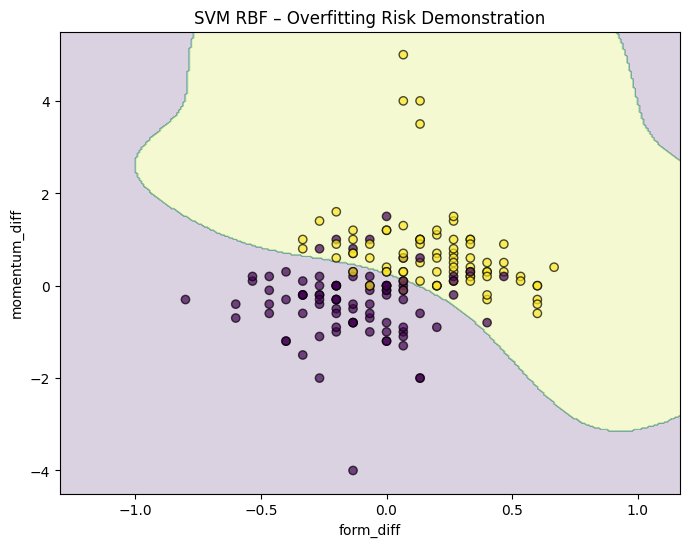

In [17]:
svm_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

svm_rbf.fit(X, y)
plot_decision_boundary(
    svm_rbf,
    X,
    y,
    "SVM RBF – Overfitting Risk Demonstration"
)


In [18]:
svm_model = svm.named_steps["model"]
scaler = svm.named_steps["scaler"]

X_scaled = scaler.transform(X)

support_indices = svm_model.support_
support_vectors = X.iloc[support_indices]
support_labels = y.iloc[support_indices]

len(support_vectors)


59

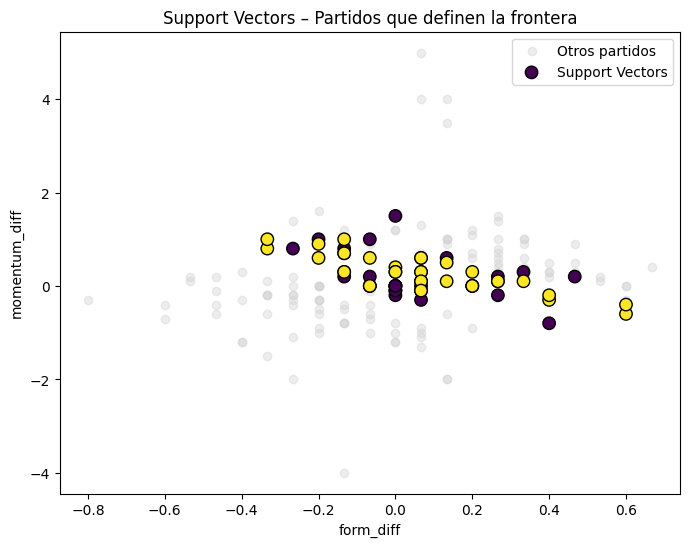

In [19]:
plt.figure(figsize=(8, 6))

# Todos los partidos
plt.scatter(
    X["form_diff"],
    X["momentum_diff"],
    c="lightgray",
    alpha=0.4,
    label="Otros partidos"
)

# Support vectors
plt.scatter(
    support_vectors["form_diff"],
    support_vectors["momentum_diff"],
    c=support_labels,
    edgecolor="black",
    s=80,
    label="Support Vectors"
)

plt.xlabel("form_diff")
plt.ylabel("momentum_diff")
plt.title("Support Vectors – Partidos que definen la frontera")
plt.legend()
plt.show()


In [21]:
# Zona gris: partidos cerca de la frontera
gray_zone_mask = np.abs(margin_distance) < 0.3

X_gray = X[gray_zone_mask]
y_gray = y[gray_zone_mask]
log_probs_gray = log_reg.predict_proba(X_gray)[:, 1]


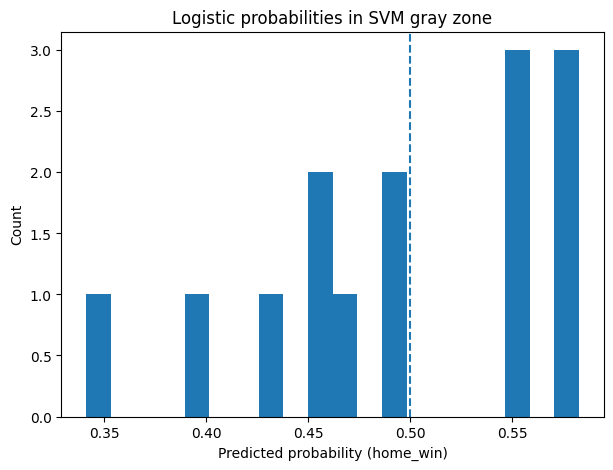

In [22]:
plt.figure(figsize=(7, 5))
plt.hist(log_probs_gray, bins=20)
plt.axvline(0.5, linestyle="--")
plt.title("Logistic probabilities in SVM gray zone")
plt.xlabel("Predicted probability (home_win)")
plt.ylabel("Count")
plt.show()


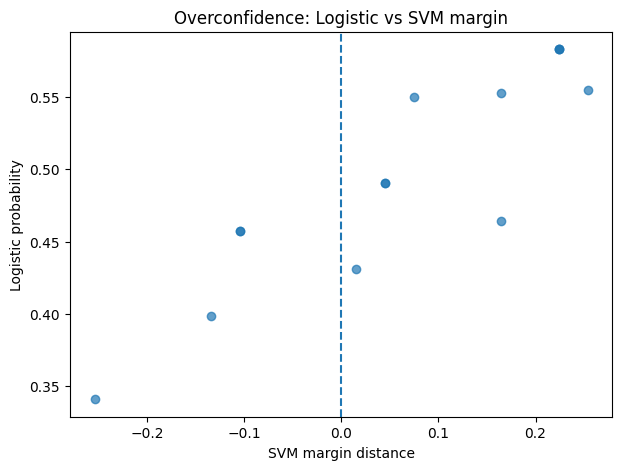

In [23]:
plt.figure(figsize=(7, 5))
plt.scatter(margin_distance[gray_zone_mask], log_probs_gray, alpha=0.7)
plt.axvline(0, linestyle="--")
plt.xlabel("SVM margin distance")
plt.ylabel("Logistic probability")
plt.title("Overconfidence: Logistic vs SVM margin")
plt.show()
